In [10]:
!pip install pennylane

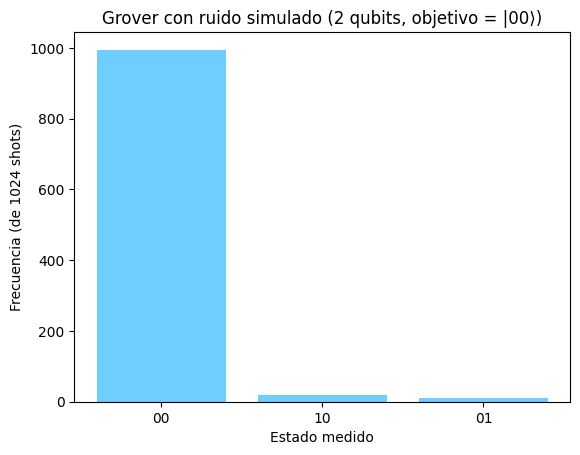

Resultados con ruido: {'00': 995, '10': 18, '01': 11}


In [12]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros ---
NUM_QUBITS = 2
wires = list(range(NUM_QUBITS))

# Usamos default.mixed para permitir ruido
dev = qml.device("default.mixed", wires=NUM_QUBITS, shots=1024)

# --- Funciones auxiliares ---

def equal_superposition(wires):
    """Prepara una superposición uniforme."""
    for wire in wires:
        qml.Hadamard(wires=wire)

def oracle(wires, omega):
    """Inversión de fase sobre el estado omega."""
    for w, bit in enumerate(omega):
        if bit == 0:
            qml.PauliX(wires=w)
    qml.ctrl(qml.PauliZ, control=wires[0])(wires[1])
    for w, bit in enumerate(omega):
        if bit == 0:
            qml.PauliX(wires=w)

def diffusion_operator(wires):
    """Inversión sobre la media (Grover diffuser)."""
    for wire in wires:
        qml.Hadamard(wires=wire)
        qml.PauliX(wires=wire)
    qml.ctrl(qml.PauliZ, control=wires[0])(wires[1])
    for wire in wires:
        qml.PauliX(wires=wire)
        qml.Hadamard(wires=wire)

# --- Canal de ruido ---
def add_noise():
    """Aplica un poco de depolarización a cada qubit para simular NISQ."""
    for wire in wires:
        qml.DepolarizingChannel(0.02, wires=wire)  # 2% de ruido por qubit

# --- Circuito principal ---
@qml.qnode(dev)
def grover_noisy():
    equal_superposition(wires)
    omega = np.array([0, 0])
    oracle(wires, omega)
    diffusion_operator(wires)
    add_noise()  # agregamos ruido al final
    return qml.sample(wires=wires)

# --- Ejecución ---
samples = grover_noisy()

# Contamos los resultados
counts = {}
for s in samples:
    key = "".join(str(int(x)) for x in s)
    counts[key] = counts.get(key, 0) + 1

# --- Visualización ---
plt.bar(counts.keys(), counts.values(), color="#70CEFF")
plt.xlabel("Estado medido")
plt.ylabel("Frecuencia (de 1024 shots)")
plt.title("Grover con ruido simulado (2 qubits, objetivo = |00⟩)")
plt.show()

print("Resultados con ruido:", counts)
